In [38]:
import spacy
import numpy as np
import pandas as pd
import re
import jsonlines
from utils.prepare_rules import create_rules 
from utils.prepare_data import create_prepare_file
from utils.expand_model import expand_model
from utils.chart import show_2_pie,show_bar_model
from utils.table import show_table, show_empty_brand
from tqdm import tqdm
import os.path
from spacy.language import Language
from spacy import displacy
import matplotlib.pyplot as plt
import ru_core_news_sm

In [39]:
BASE_PATH = ''#os.path.dirname(__file__)

DATA= BASE_PATH + 'data/pledges - pledges.csv'
BRANDS=BASE_PATH + 'data/brands.jsonl'
RULES=BASE_PATH + 'data/rules.jsonl'
DATA_PREPARE=BASE_PATH + 'data/pledges_prepare.csv'

BRAND_PATH = BASE_PATH + 'data/brands/'
RULES_PATH = BASE_PATH + 'data/rules/'

### ...Загружаем данные для парсинга и данные по брендам

Данные по брендам это подготовленный о jsonl файл со строками вида

```{"id": "CHERRY", "alias": ["черри","чери","CHERY"], "regex": []}```

Данные для парсинга это полученный от автостата файл, содержащий 10000 строк с текстом про машины

In [40]:
data = pd.read_csv(DATA, delimiter='|')

In [41]:
brands = list(jsonlines.open(BRANDS))
list_brands = [x['id'] for x in brands]

### ...Загружаем данные по моделям


По каждой марке есть словарики для модельного ряда. Например словарь для форда выглядит так:

```{"id": "S-MAX", "alias": [], "regex": []}
{"id": "FOCUS", "alias": ["ФОКУС","FUCUS","FOKUS"], "regex": []}
{"id": "FUSION", "alias": ["ФЬЮЖН"], "regex": []}
{"id": "TRANSIT", "alias": ["Транзит"], "regex": []}
{"id": "P-100", "alias": ["P100"], "regex": []}
{"id": "MONDEO", "alias": ["МОНДЕО"], "regex": []}
{"id": "ESCORT", "alias": [], "regex": []}
{"id": "C-MAX", "alias": [], "regex": []}
{"id": "RANGER", "alias": [], "regex": []}
{"id": "F-250", "alias": ["F250"], "regex": []}
{"id": "F-150", "alias": ["F150"], "regex": []}
{"id": "CARGO", "alias": [], "regex": []}
{"id": "ESCAPE", "alias": [], "regex": []}
{"id": "Explorer", "alias": [], "regex": []}
{"id": "FIESTA", "alias": [], "regex": []}
{"id": "EXCURSION", "alias": [], "regex": []}
{"id": "KUGA", "alias": [], "regex": []}
{"id": "TOURNEO", "alias": [], "regex": []}
{"id": "MAVERICK", "alias": [], "regex": []}
{"id": "GALAXY", "alias": [], "regex": []}
{"id": "IVECO", "alias": [], "regex": []}
{"id": "F550", "alias": ["DAMON DAYBREAK"], "regex": []} 
```


### ...Генерируем правила для моделей и марок и сохраняем их в файлы

Для некоторых марок сейчас не описаны их словари с моделями

In [42]:
rules = create_rules(brands)

# save in file
with jsonlines.open(RULES, mode='w') as writer:
    writer.write_all(rules)
    
for brand in list_brands:
    rules_model = create_rules(brands)
    try:
        models = jsonlines.open(BRAND_PATH + brand +'.jsonl')
        rules_model = create_rules(models, label='MODEL', prefix=brand+'_')
        with jsonlines.open(RULES_PATH + brand + '_rules.jsonl', mode='w') as writer:
            writer.write_all(rules_model)
    except:
         print('Для бренда '+ brand+ ' не найден файл с моделями')

Для бренда ACURA не найден файл с моделями
Для бренда ADR GRUP не найден файл с моделями
Для бренда ALLOY не найден файл с моделями
Для бренда AMUR не найден файл с моделями
Для бренда ASIA не найден файл с моделями
Для бренда ATLETIC не найден файл с моделями
Для бренда AVTOMASH не найден файл с моделями
Для бренда AYATS не найден файл с моделями
Для бренда BENTLEY не найден файл с моделями
Для бренда BLUMHARDT не найден файл с моделями
Для бренда BRILLIANCE не найден файл с моделями
Для бренда BSS-METACO не найден файл с моделями
Для бренда BUNGE не найден файл с моделями
Для бренда CAMC не найден файл с моделями
Для бренда CAT не найден файл с моделями
Для бренда CHAIKA-SERVIS не найден файл с моделями
Для бренда CHANGAN не найден файл с моделями
Для бренда CHANGFENG не найден файл с моделями
Для бренда CHEREAU не найден файл с моделями
Для бренда CHERRY не найден файл с моделями
Для бренда CUKUROVA не найден файл с моделями
Для бренда DACIA не найден файл с моделями
Для бренда DNES

### Попытаемся отбить пробелы

Данные приходят довольно шумные - местами отсутствуют пробелы. Поэтому берем все названия брендов и марок (больше 2 букв и нецифровых) и отбиваем их пробелами. Также отбиваем высокочастотные русские слова (год, модель, белый итп) склеенные с цифрами или англ буквами.

In [43]:
list_models = []
for brand in list_brands:
    try:
        reader = jsonlines.open(BRAND_PATH + brand +'.jsonl')
        list_models = list_models + list(reader)
    except:
#         print('Для бренда '+ brand+ ' не найден файл с правилами ' + BRAND_PATH + brand +'.jsonl')
        pass

In [44]:
str_with_space = create_prepare_file(data=data['vehicleproperty_description_short'].values, brands=brands+list_models)

data['with_space'] = str_with_space
data.to_csv(DATA_PREPARE, index=False)

Сохраняем Все что получилось в рабочий файл

In [45]:
data = pd.read_csv(DATA_PREPARE, delimiter=',')

### NER

Теперь размечаем сущности (марки, модели) в каждой строке. Всего 10000 строк.
В зависимости от компьютера исполняющего код время может варьироваться от 30сек до 1мин 20сек.

__внимание__ показатель времени не предел, его скорее всего можно сократить

In [46]:
rules = list(jsonlines.open(RULES))
for brand in list_brands:
    if os.path.exists(RULES_PATH + brand + '_rules.jsonl'):
            file = jsonlines.open(RULES_PATH + brand + '_rules.jsonl')
            rules = rules + (list(file))

In [47]:
colors = {"BRAND": "#aa9cfc", "MODEL": "#fc9ce7"}
options = {"ents": ["BRAND", "MODEL"], "colors": colors}

nlp = ru_core_news_sm.load(exclude=['tok2vec', 'morphologizer', 'parser', 'senter', 'attribute_ruler', 'lemmatizer'])

config = { "overwrite_ents": True }
ruler = nlp.add_pipe("entity_ruler", before="ner", config=config) #.from_disk(RULES_PATH +"all_rules.jsonl", )
ruler.add_patterns(rules)

nlp.add_pipe("expand_model", after="ner")

ents_info = []
html=[]
for article in data['with_space']:
    article = str(article)
    doc = nlp(article)
    ents_info.append(doc.user_data)
    html.append(doc if len(doc.ents) == 0 else displacy.render(doc, style="ent", jupyter=False, options=options))
    


In [48]:
ents_info_df = pd.DataFrame.from_records(ents_info)
data.index.name = 'order'
data = data.join(ents_info_df,on='order')
data = data.assign(HTML = html)
data.index.name= 'id'

### График опознанных брендов и моделей

Далее две круговых диаграммы, первая показывает в скольких строках распознанно брендов.
Возможно есть ошибки, потому как в строках есть название продавца/двигателя, который совпадает с брендом.
Но эту проблему можно минимизировать (проверить 2-3 предыдущих токена и если они равны ООО, ЗАО, двигатель, изготовитель и пр) испключить эту сущность (марку бренд).

На второй диаграмме показано сколько моделей было обнаружено среди строк в которых обнаружен бренд. 
синяя область - это строки в которых найденная модель соответствует модельному ряду бренда.
оранжевая область - это строки в которых найденная модель не бьется с брендом - это скорее всего ошибки
зеленая - это строки где модель не была найдена


__внимание__
<li>показатель найденных брендов может быть увеличен, когда мы сами определим что из строки бренд (я не везде смогла это понять)</li>
<li>показатель найденных моделей может быть значительно увеличен, после создания словарей для всех брендов (см диаграмму ниже)</li>
<li>точность определения модели может быть также повышена путем поиска для каждого бренда только моделей из его модельного ряда</li>

/home/cosysoft/Documents/autostat/autostat/utils/chart.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data[data['count_models']!=0][data['have_fit_model'] == False].shape[0],


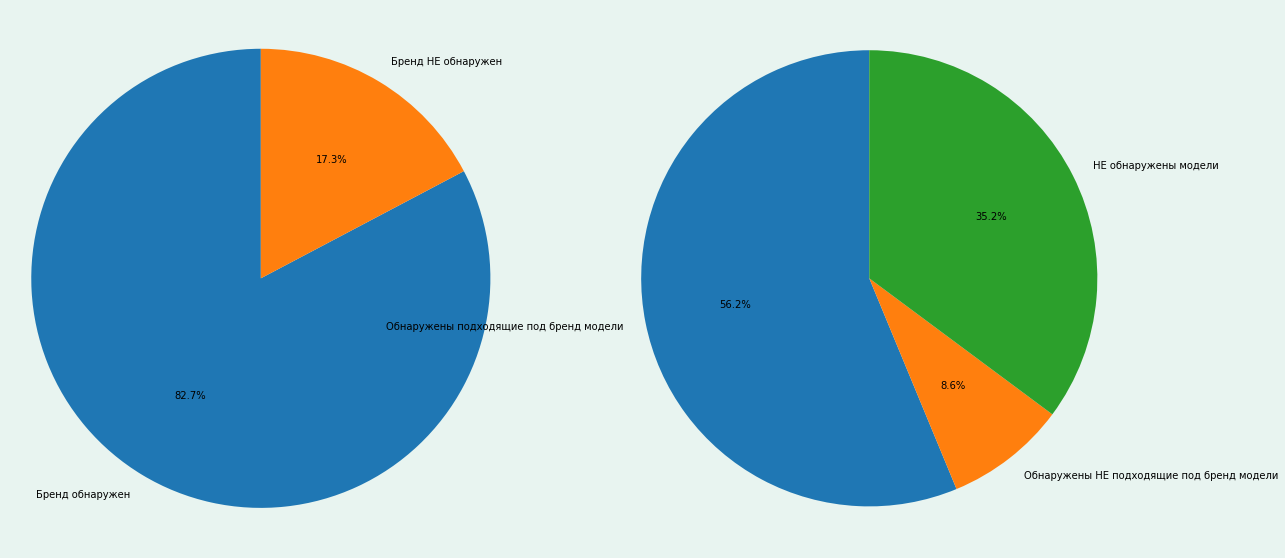

In [49]:
show_2_pie(data)

Ниже 3 диаграмма - столбики бренды. 

<li>Синий - модели нет</li>
<li>Оранжевый модель не та</li>
<li>Зеленый -модель из модельного ряда</li>


по оси Y количество найденных строк для бренда. Диаграмма разрезана на части чтобы ее было легче смотреть.

Бренды для которых зеленого сного - это бренды с подготовленными словарями.

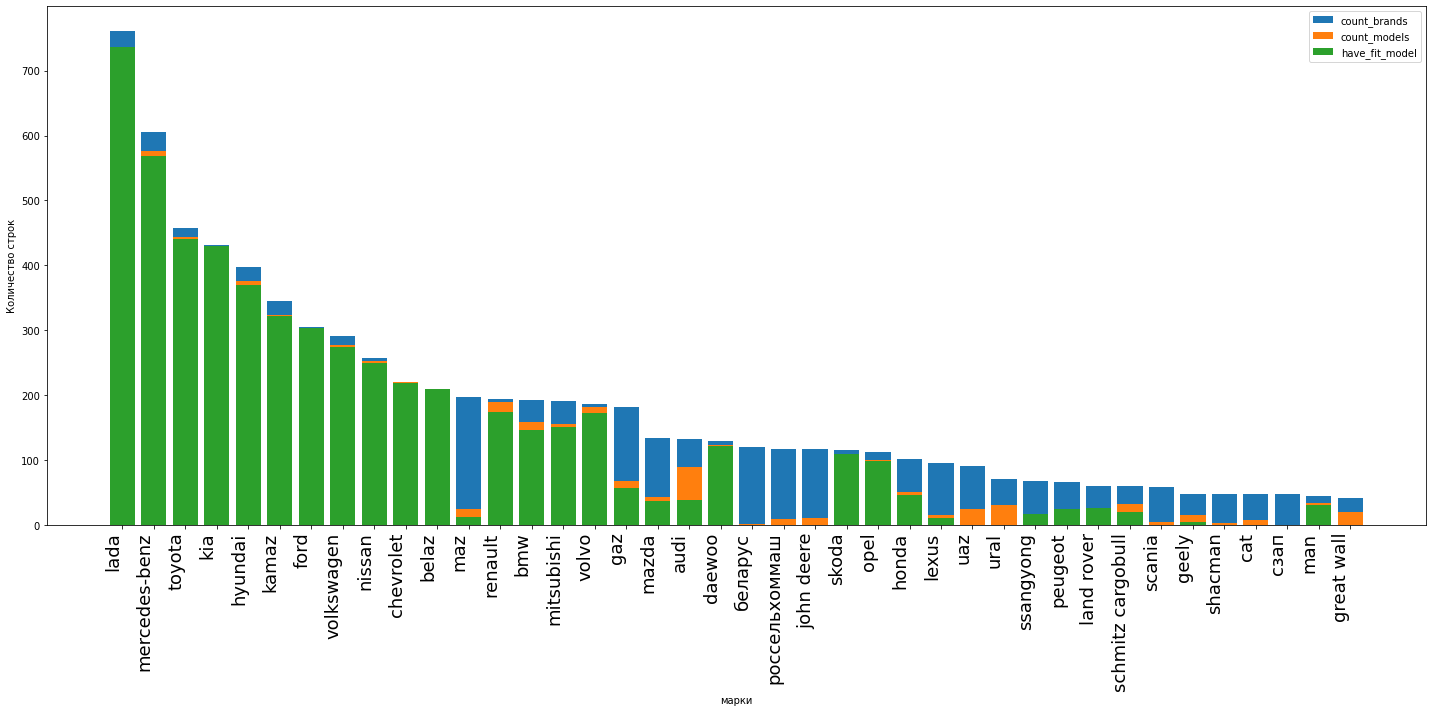

In [50]:
show_bar_model(data, 0, 40)

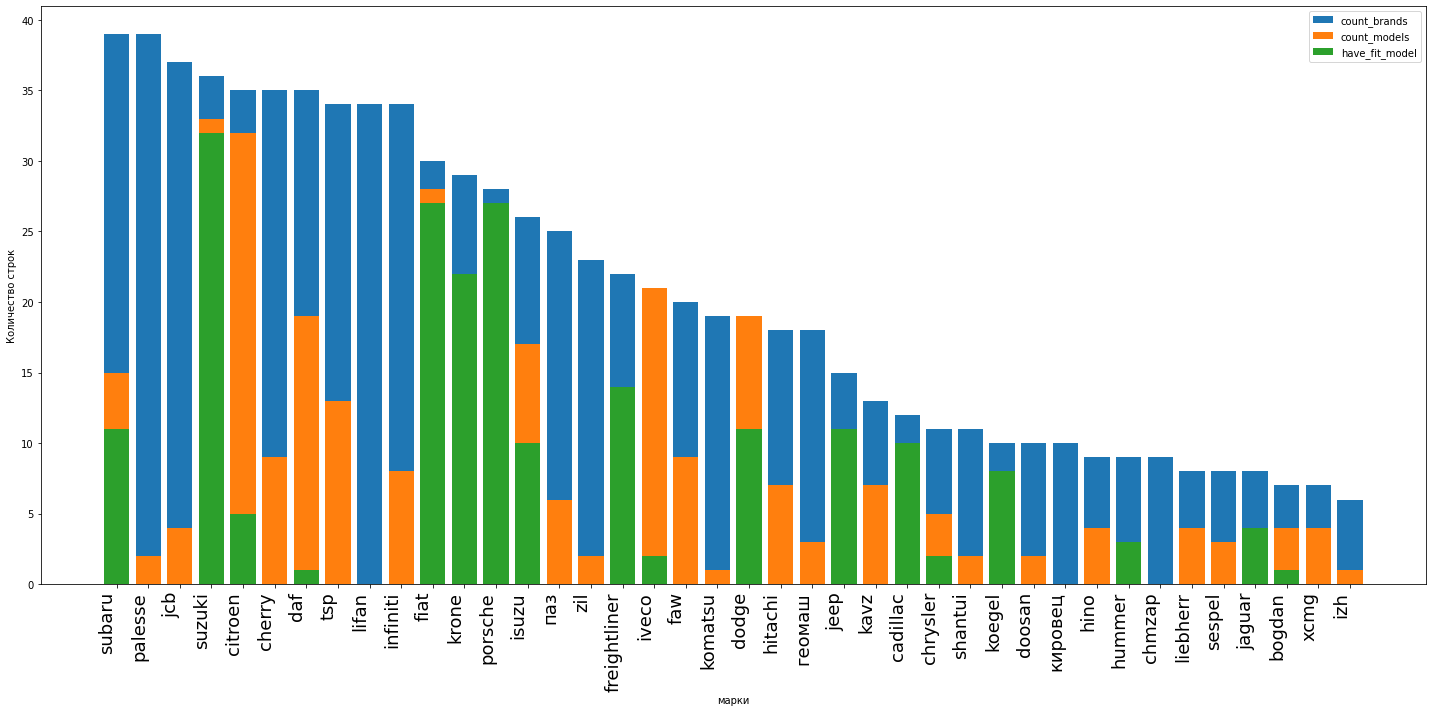

In [51]:
show_bar_model(data, 40, 80)

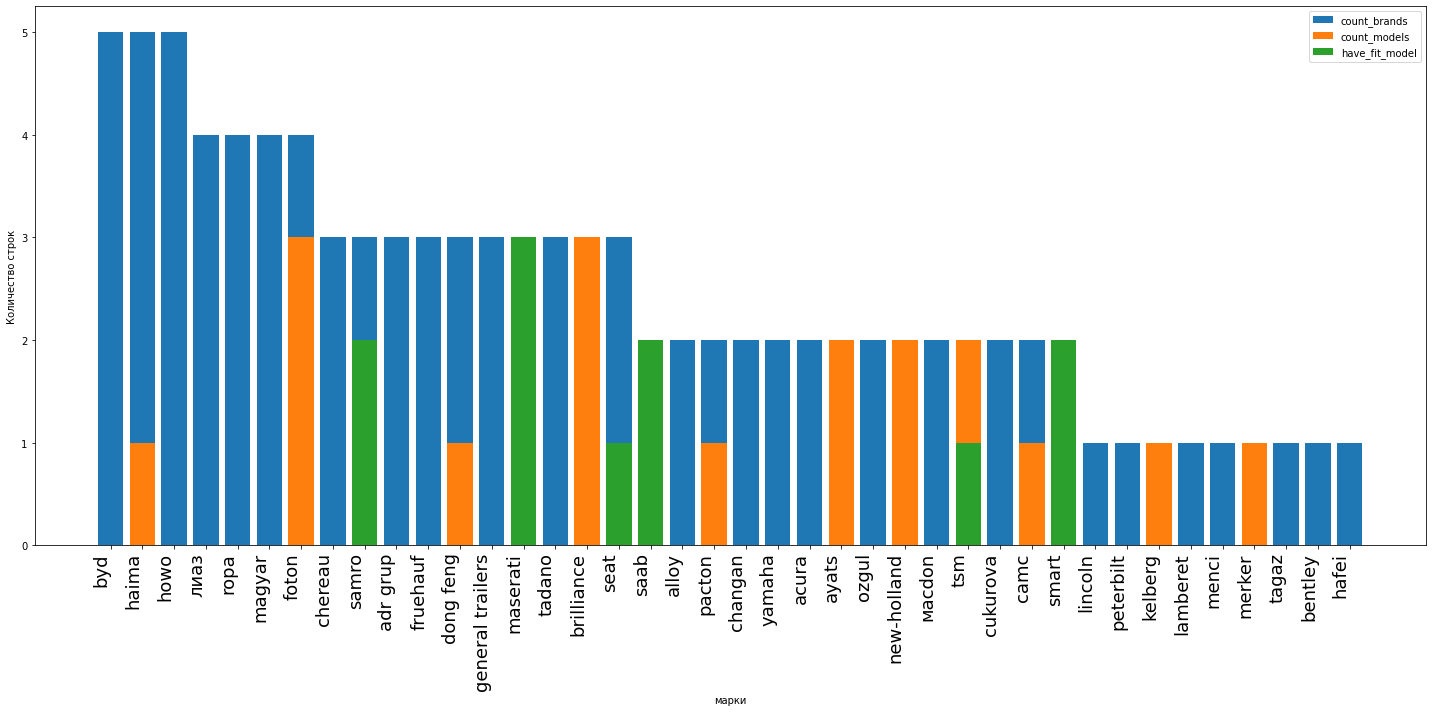

In [52]:
show_bar_model(data, 80, 120)

Ниже представлен таблица в которой не найден ни один бренд.

In [53]:
finaly_df = show_empty_brand(data=data, start=0, end=400)
finaly_df.style

Count rows  1727


,HTML,brands,models,have_fit_model,count_brands,count_models
id,,,,,,
0,Автомобиль,,,False,0,0
8,Автомобиль,,,False,0,0
9,bvv,,,False,0,0
65,Марка-Экскаватор Одноковшовый ЭО-2202 Год выпуска 2010 Заводской № машины (рамы) 00229/808102344 Номер двигателя 511316 Коробка передач № 323993 Основной ведущий мост (мосты) № 622219/0710302-04 Цвет сине-желтый Вид движения колесный Регистрационный знак 22 МС 8730 паспорт самоходной машины ВЕ 416060,,,False,0,0
86,Грузовой-тягач специальный2012 г.в.гос.номер Х692РН69марка 470104 на шасси МЕRCEDES-BENZмодель № двиг. ОМ501LА54197600499190шасси WDB9340321L192438 цвет белыймощность двиг. 320 л.с.раб. V MODEL двиг. 11946 куб.см.разрешенная макс. масса 18000 кг.масса без нагрузки 7000 кг.страна Россия,,mercedes-benz_v-class,False,0,1
95,Полуприцеп-топливнозаправщик ППЦТ-176; 2012 года выпускацвет: белыйПТС №31 НМ 669567 выдан 20.07.2012 адрес местонахождения: г.Владимирмкр.Юрьевецул.Ноябрьскаяд.138.,,,False,0,0
96,Полуприцеп-топливнозаправщик ППЦТ-27; 2012 года выпускацвет: белыйПТС №31 НМ 669568 выдан 20.07.2012 адрес местонахождения: г.Владимирмкр.Юрьевецул.Ноябрьскаяд.138.,,,False,0,0
97,Автопогрузчик HELI CPQD15 (FG15) ; 2012 года выпускацвет: оранжевыйТС №233057 выдан 09.12.2012 адрес местонахождения: г.Владимирмкр.Юрьевецул.Ноябрьскаяд.138.,,,False,0,0
108,АВТОМОБИЛЬ-ФУРГОН23210ВБ 207 гшода выпускацвет - белый,,,False,0,0


Дальше пример таблица для бренда scania и строки с не обнаруженными для нее моделями.

In [54]:
finaly_df = show_table(data=data, brand = 'scania', start=0, end=400)
finaly_df.style

Count rows  58


,HTML,brands,models,have_fit_model,count_brands,count_models
id,,,,,,
48,SCANIA BRAND R124CB6X6HZ3602003 Г.В.ПТС: 77 ТM 063767 от 15/10/2003 г. Цвет белый.,scania,,False,1,0
202,ГРУЗОВОЙ ТЯГАЧ СЕДЕЛЬНЫЙ SCANIA BRAND P 400 CA6X4HSZ 2013 года выпуска,scania,,False,1,0
252,SCANIA BRAND G 400 MODEL LA4X2HNA грузовой тягач седельный2012 года выпуска,scania,mercedes-benz_g-class,False,1,1
303,ИПВ 6730T4 Грузовой самосвал SCANIA BRAND P380 2011 г.в.,scania,,False,1,0
304,ИПВ 6730Т4 (Грузовой самосвал SCANIA BRAND P380) 2011 г.в.,scania,,False,1,0
313,Грузовой тягач седельный SCANIA BRAND R400LA4X2HLA,scania,,False,1,0
314,Грузовой тягач седельный SCANIA BRAND R400LA4X2HLA,scania,,False,1,0
315,Грузовой тягач седельный SCANIA BRAND R400LA4X2HLA,scania,,False,1,0
316,Грузовой тягач седельный SCANIA BRAND R400LA4X2HLA,scania,,False,1,0


## Вопросы

Какой разультат будет необходимым и достаточным?
<li> по времени обработки 10000 строк</li>
<li> по количеству определенных брендов </li>
<li> по количеству определенных марок </li>

Определяя модель, какая точность требуется например у КАМАЗ есть очень очень много цифровых моделей - нужны все вариации или их нужно как-то группировать?
